In [1]:
K = NumberField(x-1,'z') #need to construct this number field isomorphic to QQ, as working directly over QQ gives errors
OK = K.ideal(1) #this is isomorphic to ZZ
#Added bonus of this workaround is that we can use the following definitions for different fields

In [2]:
def DenominatorSize(q, afrak):
    '''
    INPUT: q rational number -> a/b, afrak fractional ideal in QQ
    OUTPUT: denominator size N(b)/N(cfrak), where cfrak = (a) + b*afrak^(-1)
    '''
    if q not in QQ:
        raise ValueError("first input should be a rational number")
    a = q.numerator()
    b = q.denominator()
    cfrak = a*OK + b*afrak^(-1)
    D = b*OK.norm()/cfrak.norm()
    return D

In [3]:
def newFareySum(q1, q2, afrak):
    '''
    INPUT: q1, q2 rational numbers, afrak fractional ideal in QQ
    OUTPUT: Farey sum (D(q1)*q1+D(q2)*q2)/(D(q1)+D(q2)) rational number
    '''
    if q1 not in QQ or q2 not in QQ:
        raise ValueError("first two inputs should be two rational numbers")
    D1 = DenominatorSize(q1,afrak)
    D2 = DenominatorSize(q2,afrak)
    sum = (D1*q1+D2*q2)/(D1+D2)
    return sum

In [4]:
def BoundarySphere(q1, q2):
    '''
    INPUT: q1, q2 rational numbers
    OUTPUT: [c, r] with c centre and r radius of the sphere of points equidistant from q1 and q2
    '''
    if q1 not in QQ or q2 not in QQ:
        raise ValueError("first two inputs should be two rational numbers")
    n1 = q1.numerator() #alpha
    n2 = q2.numerator() #gamma
    d1 = q1.denominator() #beta
    d2 = q2.denominator() #delta
    c = (n1*d1-n2*d2)/(d1^2-d2^2) #|(alpha beta - gamma delta)/(beta^2 - delta^2)|
    r = abs(1/(d1^2-d2^2)) #1/|beta^2 - delta^2|
    return c, r

In [5]:
def newFareyVertices(L, afrak, seq = False):
    '''
    INPUT: L non-negative integer, afrak fractional ideal of QQ, a Boolean that is False by default
    OUTPUT: dictionary of vertices in the Farey sequence of level L with a list of their two neighbours, dictionary of the centres and radii of the boundary spheres of neighbouring Farey numbers, if seq == True also the list of vertices, which is the Farey sequence of level L
    '''
    if L not in ZZ or L < 0:
        raise ValueError("input should be a non-negative integer")
    sequence = [0, 1] #list of rationals of the Farey sequence
    vertices = {0: (), 1: ()} #dictionary: keys are rationals in the Farey sequence, for each key we have a tuple of the (at most two) neighbouring rationals
    spheres = {0: (), 1: ()} #dictionary: keys are rationals in the Farey sequence, for each key we have a list [c,r] of the centre and radius of boundary sphere with the neighbouring rationals
    for i in range(L): #we iterate on the level to build the sequence
        length = len(sequence) - 1
        sequencesums = [newFareySum(sequence[j], sequence[j+1], afrak) for j in range(length)] #this is a list of the Farey sums of consecutive entries of the sequence
        for j in range(length):
            vertices[sequencesums[j]] = sequence[j], sequence[j+1] #each new Farey number found in 'sequencesums' is a new key in the dictionary 'vertices', and to it we associate its two neighbours found in 'sequence'
            c0, r0 = BoundarySphere(sequencesums[j],sequence[j])
            c1, r1 = BoundarySphere(sequencesums[j],sequence[j+1])
            x = abs((r0^2-r1^2+c1^2-c0^2)/(2*(c1-c0)))
            spheres[sequencesums[j]] = (c0, r0), (c1, r1), x,  #each new Farey number found in 'sequencesums' is a new key in the dictionary 'spheres', and to it we associate the data of the boundary spheres with its two neighbours
        newsequence = []
        for k in range(length): #this for loop creates a sequence alternating entries from the previous level with entries from 'sequencesums'
            newsequence.append(sequence[k])
            newsequence.append(sequencesums[k])
        newsequence.append(1)
        sequence = newsequence
    if seq == True:
        return vertices, spheres, sequence
    return vertices, spheres

In [6]:
def newFareyTree(L, afrak):
    '''
    INPUT: L non-negative integer, afrak a fractional ideal in QQ
    OUTPUT: graph of the Farey sequence of level L
    '''
    if L not in ZZ or L < 0:
        raise ValueError("input should be a non-negative integer")
    coordinates = [(0,0), (1,0)] #this will be the list of all the points (q, (L-1-level of q)/(L-1)) for q rational number in Farey sequence
    lines = line([(0,0),(0,1)], linestyle = '--') + line([(1,0),(1,1)], linestyle = '--') #this gives vertical dashed lines at 0 and 1, we will add lines between points to this
    if L == 0:
        return plot(lines)
    if L == 1: #case treated separately to avoid division by 0 in general case
        return plot(lines + point((1/2,1), marker = 'o'))
    if L > 1:
        vertices = newFareyVertices(L, afrak)[0]
        rationals = [*vertices] #we take keys of the dictionary FareyVertices(L) as a list, so we get all the rational numbers in the Farey sequence of level L ordered according to the level they appeared at
        for i in range(L):
            coordinates.extend([(q,(L-1-i)/(L-1)) for q in rationals[1+2^i:1+2^(i+1)]]) #coordinates 
        for p in coordinates[-1:2:-1]: #we draw lines starting from the bottom
            if DenominatorSize(vertices[p[0]][0], afrak) > DenominatorSize(vertices[p[0]][1], afrak): #this if checks which neighbour is connected to the point we are considering: it's always that with bigger denominator
                proot = vertices[p[0]][0]
            else:
                proot = vertices[p[0]][1]
            lines = lines + line([p,(proot,p[1]+1/(L-1))])
        return plot(lines)

In [7]:
def SphereInfluenceFarey(L, afrak):
    '''
    INPUT: L non-negative integer, afrak a fractional ideal in QQ
    OUTPUT: approximation of the sphere of influence given by the Farey sequence of level L
    '''
    if L not in ZZ or L < 0:
        raise ValueError("input should be a non-negative integer")
    arcs = plot(line([(1/2, 1/2),(1/2, (1/12)^(1/2))], thickness=0.5))  #this is the empty plot, we will add arcs from the boundary spheres to this
    if L == 0:
        return arcs
    if L > 0:
        vertices, spheres = newFareyVertices(L+1, afrak)#here we are producing the data for one extra level
        rationals = [*vertices] #we take keys of the dictionary FareyVertices(L) as a list, so we get all the rational numbers in the Farey sequence of level L ordered according to the level they appeared at
        for q in rationals[2:2+2^(L-1)]:#we just consider the rationals in the Farey sequence of level L that are not 0 or 1
            (c0, r0), (c1, r1), cross = spheres[q]#these are centres and radii of boundary circumferences of q, cross is the x-coordinate where the arcs meet
            leaf_0 = newFareySum(q, vertices[q][0], OK)#leaf_i are the rationals that arise in the Farey sequence by summing another rational with q
            leaf_1 = newFareySum(q, vertices[q][1], OK)
            cross0 = spheres[leaf_0][2] #arcs end at the "cross" of the leaves stemming from q
            cross1 = spheres[leaf_1][2]
            arcs = arcs + plot((r0^2-(x-c0)^2)^(1/2), (x, cross0, cross), thickness=0.5) + plot((r1^2-(x-c1)^2)^(1/2), (x, cross, cross1), thickness=0.5)
        return arcs

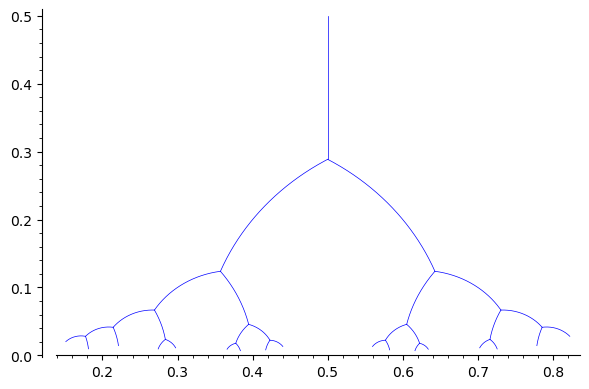

In [8]:
SphereInfluenceFarey(5, OK)

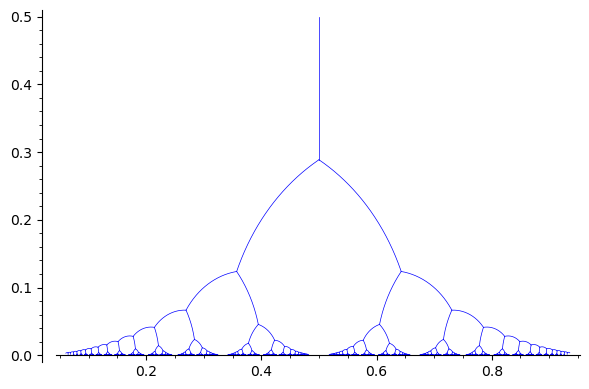

In [9]:
SphereInfluenceFarey(15, OK)